In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A

import numpy as np
from tqdm import tqdm

import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt

import cv2
from torchvision.utils import save_image
from albumentations.pytorch.transforms import ToTensorV2

# Sources:

https://github.com/junyanz/CycleGAN

https://www.youtube.com/watch?v=4LktBHGCNfw&ab_channel=AladdinPersson (Реализация циклогана из статьи, все действия автор объясняет)

# Data loading

In [2]:
class MonetDataSet(Dataset):
    def __init__(self, photos_path, images_path, transform=None):
        self.photos_names = os.listdir(photos_path)
        self.images_names = os.listdir(images_path)
        self.transform = transform
        
        self.photos = []
        self.images = []
        for i in range(len(self.photos_names)):
            self.photos.append(Image.open(os.path.join(photos_path, self.photos_names[i])).convert('RGB'))
        for i in range(len(self.images_names)):
            self.images.append(Image.open(os.path.join(images_path, self.images_names[i])).convert('RGB'))
        
        self.photos_len = len(self.photos)
        self.images_len = len(self.images)
        
    def __len__(self):
        return max(self.photos_len, self.images_len)
    
    def __getitem__(self, idx):
        photo = np.array(self.photos[idx % self.photos_len])
        image = np.array(self.images[idx % self.images_len])
        
        if self.transform is not None:
            albumentations = self.transform(image=photo, image0=image)
            photo = albumentations['image']
            image = albumentations['image0']
        
        return photo, image


In [3]:
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={'image0':'image'},
)

In [4]:
photos_path = '../input/gan-getting-started/photo_jpg'
images_path = '../input/gan-getting-started/monet_jpg'

data = MonetDataSet(photos_path=photos_path, images_path=images_path, transform=transform)

In [5]:
data.images_len, data.photos_len

(300, 7038)

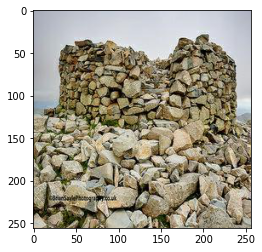

In [6]:
plt.imshow(data[3][0].permute(1, 2, 0) * 0.5 + 0.5)

# Generator

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down_sampling=True, activation=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs)
            if down_sampling is True
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if activation is True else nn.Identity()
        )
        
    def forward(self, x):
        return self.conv(x)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, activation=False, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        return x + self.block(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, channels, features=64, res_num=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(channels, features, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(inplace=True)
        )
        
        self.down = nn.ModuleList(
            [
                ConvBlock(features, features * 2, kernel_size=3, stride=2, padding=1),
                ConvBlock(features * 2, features * 4, kernel_size=3, stride=2, padding=1),
            ]
        )
        
        self.residual = nn.Sequential(
            *[ResidualBlock(features * 4) for _ in range(res_num)]
        )
        
        self.up = nn.ModuleList(
            [
                ConvBlock(features * 4, features * 2, down_sampling=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(features * 2, features * 1, down_sampling=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )
        
        self.final = nn.Conv2d(features, channels, kernel_size=7, stride=1, padding=3, padding_mode='reflect')
        
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down:
            x = layer(x)   
        x = self.residual(x)
        for layer in self.up:
            x = layer(x)
            
        return torch.tanh(self.final(x))

# Discriminator

In [10]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.conv(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.initial(x)
        
        return torch.sigmoid(self.model(x))
            

# Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
LR = 2e-4    # Из туториала
EPOCHS = 3
BATCH_SIZE = 1

cycle_coef = 10
identity_coef = 1

In [14]:
disc_P = Discriminator(in_channels=3).to(device)
disc_I = Discriminator(in_channels=3).to(device)

gen_P = Generator(channels=3).to(device)
gen_I = Generator(channels=3).to(device)

disc_optimizer = torch.optim.Adam(
    list(disc_P.parameters()) + list(disc_I.parameters()),
    lr=LR,
    betas=(0.5, 0.999)
)

gen_optimizer = torch.optim.Adam(
    list(gen_P.parameters()) + list(gen_I.parameters()),
    lr=LR,
    betas=(0.5, 0.999)
)

disc_scaler = torch.cuda.amp.GradScaler()
gen_scaler = torch.cuda.amp.GradScaler()

l1 = nn.L1Loss()
mse = nn.MSELoss()

In [15]:
loader = DataLoader(data, BATCH_SIZE, shuffle=False)

In [16]:
def model_save(model, model_name, optimizer, epoch, i):
    current_state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(current_state, f"{model_name}_{epoch}_{i}.pth")

In [17]:
for epoch in range(EPOCHS):
    for i, (photo, image) in tqdm(enumerate(loader)):
        photo = photo.float().to(device)
        image = image.float().to(device)
        
        with torch.cuda.amp.autocast():
            fake_image = gen_I(photo)
            D_I_real = disc_I(image)
            D_I_fake = disc_I(fake_image.detach())
            D_I_real_loss = mse(D_I_real, torch.ones_like(D_I_real))
            D_I_fake_loss = mse(D_I_fake, torch.zeros_like(D_I_fake))
            D_I_loss = D_I_real_loss + D_I_fake_loss
            
            fake_photo = gen_P(image)
            D_P_real = disc_P(photo)
            D_P_fake = disc_P(fake_photo.detach())
            D_P_real_loss = mse(D_P_real, torch.ones_like(D_P_real))
            D_P_fake_loss = mse(D_P_fake, torch.zeros_like(D_P_fake))
            D_P_loss = D_P_real_loss + D_P_fake_loss
            
            D_loss = (D_I_loss + D_P_loss) / 2
            
        disc_optimizer.zero_grad()
        disc_scaler.scale(D_loss).backward()
        disc_scaler.step(disc_optimizer)
        disc_scaler.update()
        
        with torch.cuda.amp.autocast():
            D_I_fake = disc_I(fake_image)
            D_P_fake = disc_P(fake_photo)
            loss_G_I = mse(D_I_fake, torch.ones_like(D_I_fake))
            loss_G_P = mse(D_P_fake, torch.ones_like(D_P_fake))
            
            cycle_photo = gen_P(fake_image)
            cycle_image = gen_I(fake_photo)
            cycle_photo_loss = l1(photo, cycle_photo)
            cycle_image_loss = l1(image, cycle_image)
            
            identity_photo = gen_P(photo)
            identity_image = gen_I(image)
            identity_photo_loss = l1(photo, identity_photo)
            identity_image_loss = l1(image, identity_image)
            
            G_loss = (
                loss_G_P + loss_G_I + cycle_photo_loss * cycle_coef + cycle_image_loss * cycle_coef + identity_photo_loss + identity_image_loss
            )
            
        gen_optimizer.zero_grad()
        gen_scaler.scale(G_loss).backward()
        gen_scaler.step(gen_optimizer)
        gen_scaler.update()
        
        if i % 300 == 0:
            print(f'EPOCH: {epoch + 1}, D_P_LOSS: {D_P_loss.item()}, D_I_LOSS: {D_I_loss.item()}, G_P_loss: {loss_G_P.item()}, G_I_LOSS: {loss_G_I.item()}')
#             model_save(gen_I, 'Generator', gen_optimizer, epoch, i)
#             model_save(disc_I, 'Discriminator', disc_optimizer, epoch, i)
            

1it [00:06,  6.19s/it]

EPOCH: 1, D_P_LOSS: 0.5128324627876282, D_I_LOSS: 0.5311972498893738, G_P_loss: 0.356359601020813, G_I_LOSS: 0.37199434638023376


301it [03:15,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.44808119535446167, D_I_LOSS: 0.36809876561164856, G_P_loss: 0.2708451747894287, G_I_LOSS: 0.5616180896759033


601it [06:24,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.40446072816848755, D_I_LOSS: 0.6115483045578003, G_P_loss: 0.2847750186920166, G_I_LOSS: 0.39921095967292786


901it [09:34,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.3805069327354431, D_I_LOSS: 0.39696377515792847, G_P_loss: 0.36582353711128235, G_I_LOSS: 0.6665135622024536


1201it [12:43,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.629080057144165, D_I_LOSS: 0.3218556344509125, G_P_loss: 0.3521191477775574, G_I_LOSS: 0.5171258449554443


1501it [15:52,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.29772818088531494, D_I_LOSS: 0.4454594850540161, G_P_loss: 0.4795921742916107, G_I_LOSS: 0.3963632583618164


1801it [19:02,  1.56it/s]

EPOCH: 1, D_P_LOSS: 0.47302305698394775, D_I_LOSS: 0.4031263589859009, G_P_loss: 0.36297252774238586, G_I_LOSS: 0.5995264053344727


2101it [22:11,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.48827117681503296, D_I_LOSS: 0.2571589946746826, G_P_loss: 0.42922791838645935, G_I_LOSS: 0.5721794962882996


2401it [25:20,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.2918492257595062, D_I_LOSS: 0.38156968355178833, G_P_loss: 0.4741733968257904, G_I_LOSS: 0.4763800799846649


2701it [28:30,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.35018202662467957, D_I_LOSS: 0.31733426451683044, G_P_loss: 0.353316068649292, G_I_LOSS: 0.5263118743896484


3001it [31:39,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.4025934934616089, D_I_LOSS: 0.3325873911380768, G_P_loss: 0.44507041573524475, G_I_LOSS: 0.506577730178833


3301it [34:48,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.21584895253181458, D_I_LOSS: 0.24926602840423584, G_P_loss: 0.48147842288017273, G_I_LOSS: 0.5127967000007629


3601it [37:58,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.30245837569236755, D_I_LOSS: 0.3291386663913727, G_P_loss: 0.42281007766723633, G_I_LOSS: 0.45989882946014404


3901it [41:08,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.6214401721954346, D_I_LOSS: 0.5866866111755371, G_P_loss: 0.4152638614177704, G_I_LOSS: 0.2488817572593689


4201it [44:17,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.33024248480796814, D_I_LOSS: 0.33765819668769836, G_P_loss: 0.3463273048400879, G_I_LOSS: 0.6102285385131836


4501it [47:27,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.32773613929748535, D_I_LOSS: 0.3138386309146881, G_P_loss: 0.478350430727005, G_I_LOSS: 0.5760942101478577


4801it [50:37,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.13890966773033142, D_I_LOSS: 0.2211182564496994, G_P_loss: 0.514779806137085, G_I_LOSS: 0.7074125409126282


5101it [53:46,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.24524274468421936, D_I_LOSS: 0.3299022316932678, G_P_loss: 0.49894195795059204, G_I_LOSS: 0.5955314040184021


5401it [56:56,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.3452739119529724, D_I_LOSS: 0.36674314737319946, G_P_loss: 0.35717859864234924, G_I_LOSS: 0.4390828609466553


5701it [1:00:05,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.31120815873146057, D_I_LOSS: 0.41606372594833374, G_P_loss: 0.3990207612514496, G_I_LOSS: 0.5503703355789185


6001it [1:03:14,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.47516870498657227, D_I_LOSS: 0.45110470056533813, G_P_loss: 0.32219985127449036, G_I_LOSS: 0.40911731123924255


6301it [1:06:24,  1.57it/s]

EPOCH: 1, D_P_LOSS: 0.5226098299026489, D_I_LOSS: 0.3644053339958191, G_P_loss: 0.4459938108921051, G_I_LOSS: 0.4960710406303406


6601it [1:09:34,  1.59it/s]

EPOCH: 1, D_P_LOSS: 0.4295459985733032, D_I_LOSS: 0.41962915658950806, G_P_loss: 0.4430041015148163, G_I_LOSS: 0.3787640929222107


6901it [1:12:44,  1.58it/s]

EPOCH: 1, D_P_LOSS: 0.5745120048522949, D_I_LOSS: 0.6921905279159546, G_P_loss: 0.41616156697273254, G_I_LOSS: 0.215134397149086


7038it [1:14:10,  1.58it/s]
1it [00:00,  1.59it/s]

EPOCH: 2, D_P_LOSS: 0.5795257091522217, D_I_LOSS: 0.5445539951324463, G_P_loss: 0.5340430736541748, G_I_LOSS: 0.5119843482971191


301it [03:10,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.24581897258758545, D_I_LOSS: 0.2972763776779175, G_P_loss: 0.4143635928630829, G_I_LOSS: 0.7744671702384949


601it [06:20,  1.59it/s]

EPOCH: 2, D_P_LOSS: 0.17596197128295898, D_I_LOSS: 0.2736217677593231, G_P_loss: 0.5447905659675598, G_I_LOSS: 0.8027271628379822


901it [09:29,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.19672858715057373, D_I_LOSS: 0.1594630479812622, G_P_loss: 0.4841490387916565, G_I_LOSS: 0.7049052119255066


1201it [12:39,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.7381450533866882, D_I_LOSS: 0.359077513217926, G_P_loss: 0.41845378279685974, G_I_LOSS: 0.5108379125595093


1501it [15:49,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.5037574768066406, D_I_LOSS: 0.24936223030090332, G_P_loss: 0.3792947232723236, G_I_LOSS: 0.5343213081359863


1801it [18:59,  1.59it/s]

EPOCH: 2, D_P_LOSS: 0.2927091717720032, D_I_LOSS: 0.26679831743240356, G_P_loss: 0.37786275148391724, G_I_LOSS: 0.7417078614234924


2101it [22:09,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.254575252532959, D_I_LOSS: 0.22218777239322662, G_P_loss: 0.43755051493644714, G_I_LOSS: 0.7777434587478638


2401it [25:18,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.2960875332355499, D_I_LOSS: 0.1463095247745514, G_P_loss: 0.5611547827720642, G_I_LOSS: 0.6590681672096252


2701it [28:28,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.33364245295524597, D_I_LOSS: 0.1754794865846634, G_P_loss: 0.4534165859222412, G_I_LOSS: 0.7769292593002319


3001it [31:38,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.562058687210083, D_I_LOSS: 0.11944012343883514, G_P_loss: 0.33281204104423523, G_I_LOSS: 0.7343292832374573


3301it [34:48,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.2865295112133026, D_I_LOSS: 0.18953152000904083, G_P_loss: 0.41427329182624817, G_I_LOSS: 0.8126053214073181


3601it [37:58,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.30606234073638916, D_I_LOSS: 0.07689961791038513, G_P_loss: 0.43224120140075684, G_I_LOSS: 0.9065374135971069


3901it [41:08,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.5570343732833862, D_I_LOSS: 0.16537177562713623, G_P_loss: 0.42864951491355896, G_I_LOSS: 0.8575038313865662


4201it [44:18,  1.59it/s]

EPOCH: 2, D_P_LOSS: 0.38100630044937134, D_I_LOSS: 0.16812191903591156, G_P_loss: 0.33090394735336304, G_I_LOSS: 0.8055991530418396


4501it [47:27,  1.57it/s]

EPOCH: 2, D_P_LOSS: 0.6274840831756592, D_I_LOSS: 0.2022998034954071, G_P_loss: 0.298251748085022, G_I_LOSS: 0.881594717502594


4801it [50:37,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.1588110774755478, D_I_LOSS: 0.2367268055677414, G_P_loss: 0.5275713801383972, G_I_LOSS: 0.665917694568634


5101it [53:47,  1.59it/s]

EPOCH: 2, D_P_LOSS: 0.2740914225578308, D_I_LOSS: 0.11714515835046768, G_P_loss: 0.385189950466156, G_I_LOSS: 0.8884698748588562


5401it [56:57,  1.59it/s]

EPOCH: 2, D_P_LOSS: 0.2579571604728699, D_I_LOSS: 0.15409518778324127, G_P_loss: 0.46416741609573364, G_I_LOSS: 0.889702320098877


5701it [1:00:06,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.3085048496723175, D_I_LOSS: 0.1565873920917511, G_P_loss: 0.4186539053916931, G_I_LOSS: 0.8304112553596497


6001it [1:03:16,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.4760555028915405, D_I_LOSS: 0.14638610184192657, G_P_loss: 0.3138556182384491, G_I_LOSS: 0.8807284832000732


6301it [1:06:26,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.48355746269226074, D_I_LOSS: 0.2237112820148468, G_P_loss: 0.42763859033584595, G_I_LOSS: 0.8678746819496155


6601it [1:09:36,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.49419230222702026, D_I_LOSS: 0.24689701199531555, G_P_loss: 0.3396112024784088, G_I_LOSS: 0.8864906430244446


6901it [1:12:46,  1.58it/s]

EPOCH: 2, D_P_LOSS: 0.6396057605743408, D_I_LOSS: 0.22985070943832397, G_P_loss: 0.377312034368515, G_I_LOSS: 0.7523338794708252


7038it [1:14:13,  1.58it/s]
1it [00:00,  1.59it/s]

EPOCH: 3, D_P_LOSS: 0.5134798288345337, D_I_LOSS: 0.058249328285455704, G_P_loss: 0.4629993438720703, G_I_LOSS: 0.8989428281784058


301it [03:10,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.282660573720932, D_I_LOSS: 0.12551727890968323, G_P_loss: 0.3805118799209595, G_I_LOSS: 0.8903632760047913


601it [06:20,  1.57it/s]

EPOCH: 3, D_P_LOSS: 0.21983693540096283, D_I_LOSS: 0.0846472978591919, G_P_loss: 0.4891062080860138, G_I_LOSS: 0.9689791202545166


901it [09:30,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.27685749530792236, D_I_LOSS: 0.03824479132890701, G_P_loss: 0.4560298025608063, G_I_LOSS: 0.9676793217658997


1201it [12:40,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.6961542963981628, D_I_LOSS: 0.03930871561169624, G_P_loss: 0.38453805446624756, G_I_LOSS: 0.9833165407180786


1501it [15:50,  1.57it/s]

EPOCH: 3, D_P_LOSS: 0.5207720994949341, D_I_LOSS: 0.10805518180131912, G_P_loss: 0.37389811873435974, G_I_LOSS: 0.9209336042404175


1801it [19:00,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.23015247285366058, D_I_LOSS: 0.25166216492652893, G_P_loss: 0.46154487133026123, G_I_LOSS: 0.9644685983657837


2101it [22:10,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.20933571457862854, D_I_LOSS: 0.1375698298215866, G_P_loss: 0.45553767681121826, G_I_LOSS: 0.8916489481925964


2401it [25:21,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.3656858801841736, D_I_LOSS: 0.06949771195650101, G_P_loss: 0.44888222217559814, G_I_LOSS: 0.8965117335319519


2701it [28:31,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.18466214835643768, D_I_LOSS: 0.05214381963014603, G_P_loss: 0.5594035387039185, G_I_LOSS: 0.9534813761711121


3001it [31:41,  1.56it/s]

EPOCH: 3, D_P_LOSS: 0.4735003411769867, D_I_LOSS: 0.20435777306556702, G_P_loss: 0.43355706334114075, G_I_LOSS: 0.8858007788658142


3301it [34:51,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.18831945955753326, D_I_LOSS: 0.004263871815055609, G_P_loss: 0.5062538981437683, G_I_LOSS: 0.9698692560195923


3601it [38:01,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.3411569595336914, D_I_LOSS: 0.07120981812477112, G_P_loss: 0.4689534604549408, G_I_LOSS: 0.9188730716705322


3901it [41:12,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.4973103702068329, D_I_LOSS: 0.14860399067401886, G_P_loss: 0.4967091381549835, G_I_LOSS: 0.9587167501449585


4201it [44:22,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.3497081398963928, D_I_LOSS: 0.04745786637067795, G_P_loss: 0.36688679456710815, G_I_LOSS: 0.9729080200195312


4501it [47:33,  1.57it/s]

EPOCH: 3, D_P_LOSS: 0.5954878330230713, D_I_LOSS: 0.07047032564878464, G_P_loss: 0.47727063298225403, G_I_LOSS: 0.9466050863265991


4801it [50:43,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.1110554039478302, D_I_LOSS: 0.024957146495580673, G_P_loss: 0.5514290928840637, G_I_LOSS: 0.9828239679336548


5101it [53:53,  1.57it/s]

EPOCH: 3, D_P_LOSS: 0.23753947019577026, D_I_LOSS: 0.027702951803803444, G_P_loss: 0.4887649714946747, G_I_LOSS: 0.9852307438850403


5401it [57:03,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.2272414118051529, D_I_LOSS: 0.05987299233675003, G_P_loss: 0.518801212310791, G_I_LOSS: 0.9867265224456787


5701it [1:00:14,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.2719859182834625, D_I_LOSS: 0.05712295323610306, G_P_loss: 0.4308842122554779, G_I_LOSS: 0.9578643441200256


6001it [1:03:24,  1.57it/s]

EPOCH: 3, D_P_LOSS: 0.4235006868839264, D_I_LOSS: 0.06454340368509293, G_P_loss: 0.3924027681350708, G_I_LOSS: 0.9711263179779053


6301it [1:06:34,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.30399760603904724, D_I_LOSS: 0.05643296614289284, G_P_loss: 0.5901592969894409, G_I_LOSS: 0.9605929851531982


6601it [1:09:44,  1.58it/s]

EPOCH: 3, D_P_LOSS: 0.5332653522491455, D_I_LOSS: 0.017782391980290413, G_P_loss: 0.4136345088481903, G_I_LOSS: 0.9428067803382874


6901it [1:12:54,  1.57it/s]

EPOCH: 3, D_P_LOSS: 0.5696278810501099, D_I_LOSS: 0.31507447361946106, G_P_loss: 0.42413246631622314, G_I_LOSS: 0.9200969934463501


7038it [1:14:21,  1.58it/s]


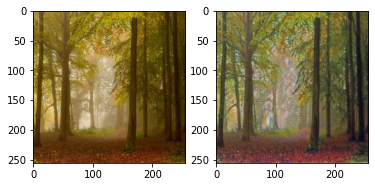

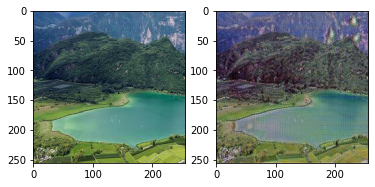

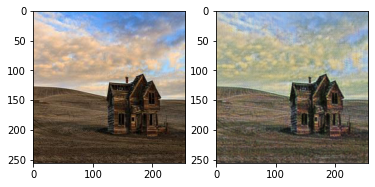

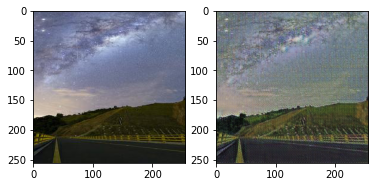

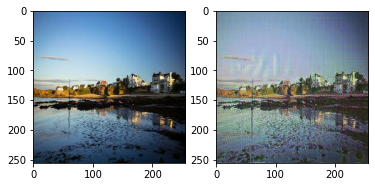

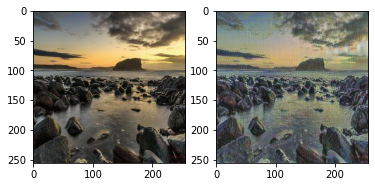

In [18]:
for idx, (photo, _) in enumerate(loader):
    if idx not in (0, 10, 20, 30, 40, 50):
        continue
    plt.subplot(1, 2, 1)
    plt.imshow(photo[0].permute(1, 2, 0) * 0.5 + 0.5)

    pattern = photo.float().to(device)
    fake = gen_I(pattern).cpu().detach()[0]
    plt.subplot(1, 2, 2)
    plt.imshow(fake.permute(1, 2, 0) * 0.5 + 0.5)
    
    plt.show()
    
    if idx > 50:
        break

# Код для сабмита из туториала

In [19]:
import os

In [20]:
os.mkdir('/kaggle/working/images/')

In [21]:
os.chdir("/kaggle/working/")

In [22]:
os.getcwd()

'/kaggle/working'

In [23]:
i = 1
for photo, _ in loader:
    prediction = gen_I(photo.float().to(device)).cpu().detach()[0]
    prediction = (prediction.permute(1, 2, 0).numpy() * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    i += 1

In [24]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")

'/kaggle/working/images.zip'

In [25]:
torch.save(gen_I.state_dict(),'/kaggle/working/model.pt')

In [26]:
#model.load_state_dict(torch.load('../input/model.pt'))